In [1]:
!pip install librosa soundfile
!pip install pydub
!apt install ffmpeg
!pip install pesq pystoi

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp311-cp311-linux_x86_64.whl size=274954 sha256=c3c51d919f51a8ac3b46ad5405e3ede20449fd6e6e737cadef22a6f5eb37fecb
  Stored in directory: /root/.cache/pip/wheels/ae/f1/23/2698d0bf31eec2b2aa50623b5d93b6206c49c7155d0e31345d
Successfully built pesq


In [2]:
# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, UpSampling1D, Concatenate, LeakyReLU
from tensorflow.keras.models import Model

# Audio processing
import librosa
import soundfile as sf

# Data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
import os, random, glob

# Used for audio display in colab, makes it easier to do sound test by ear
from IPython.display import Audio

# Audio quality metrics
from pesq import pesq
import pystoi

# For custom Adam learning rate
from tensorflow.keras.optimizers import Adam


Mounted at /content/drive


In [3]:
# Training and test data are found on google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The Wave-U-Net model is based on a model used for image generation called U-Net, which gets its name from its "U-Shaped" architecture: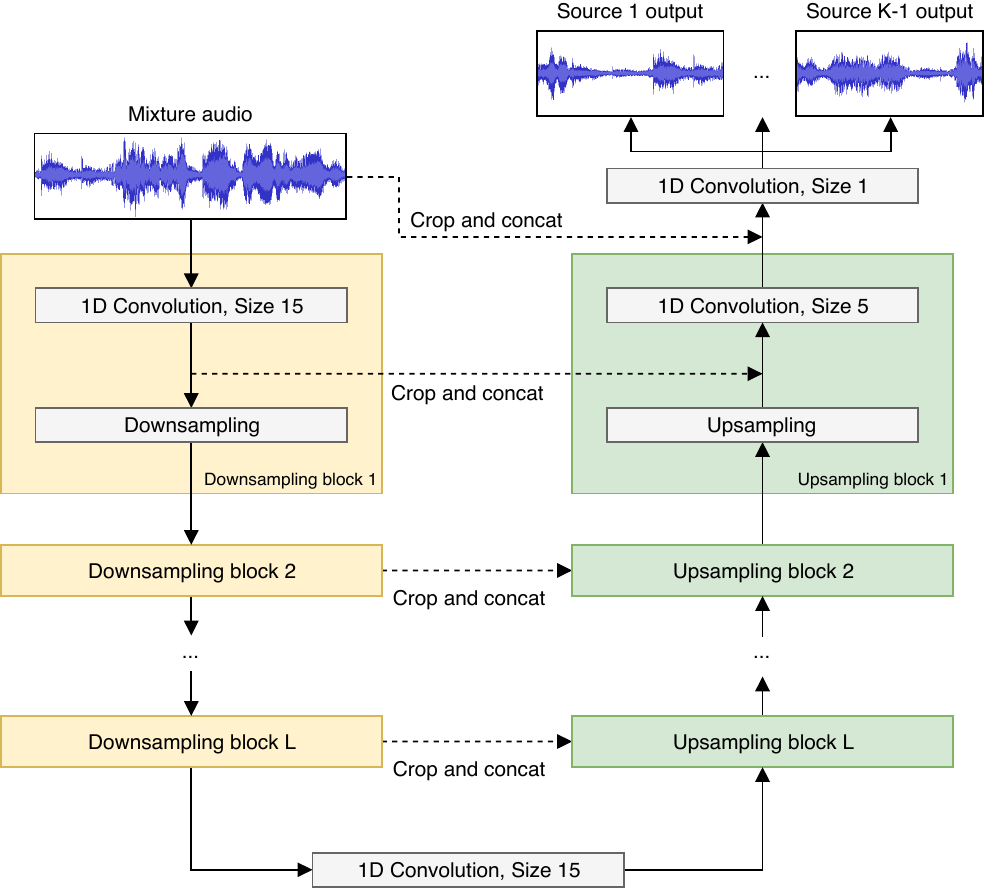

This image was sourced from https://github.com/f90/Wave-U-Net/blob/master/waveunet.png (and can also be found in the article) which is the github repository hosting the code from the paper about the model this project is based on. As can be seen from this picture, there is a U-shaped architecture with a coder/Downsampling side and a decoder/Upsampling side. Though this is a picture used for Wave-U-Net specifically, the same is true for U-Net.

In [3]:
# Function representing the downsampling block as shown in the image above
def downsampling_block(x, filters, kernel_size=15):
    x = Conv1D(filters, kernel_size, strides=2, padding='same')(x)
    #The paper says to use LeakyReLU for all but the final step where we are meant to use "tanh"
    x = LeakyReLU()(x)
    return x

In [4]:
# Function representing the upsampling block as shown in the image above
def upsampling_block(x, skip_connection, filters, kernel_size=5):
    x = UpSampling1D(size=2)(x)
    x = Concatenate()([x, skip_connection])
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = LeakyReLU()(x)
    return x

In [5]:
def wave_unet(input_shape=(None, 1), depth=4, filters=24):
    inputs = Input(shape=input_shape)
    x = inputs
    skips = []

    # Downsampling path
    for i in range(depth):
        skips.append(x)
        x = downsampling_block(x, filters * (2 ** i))

    # Bottleneck / The bottom of the "U-Shape"
    x = Conv1D(filters * (2 ** depth), kernel_size=15, padding='same')(x)
    x = LeakyReLU()(x)

    # Upsampling path
    for i in reversed(range(depth)):
         x = upsampling_block(x, skips[i], filters * (2 ** i))

    # Final layer: output same shape as input
    output = Conv1D(1, kernel_size=1, padding='same', activation='tanh')(x)

    return Model(inputs=inputs, outputs=output)

In [13]:
# Check to see if everything looks alright
# model = wave_unet()
# model.summary()

The voice clips we will use for training are .mp3 files, but we would rather have them be .wav files.

In [1]:
# This is a time consuming operation that should never be done again, I will keep
# the code here for documentation / emergencies, but commented out.
# Update: in order to try to test on unseen voiceclips I downloaded the
# collection of bokmål voiceclips. (We used nynorsk in training)
"""
from pydub import AudioSegment

input_folder = '/content/drive/MyDrive/WaveUNetDataset/teststuff/clips/'
output_folder = '/content/drive/MyDrive/WaveUNetDataset/teststuff/clipsWav/'

# Make sure output folder exists
os.makedirs(output_folder, exist_ok=True)

# Convert each MP3
for filename in os.listdir(input_folder):

      mp3_path = os.path.join(input_folder, filename)
      wav_path = os.path.join(output_folder, filename.replace('.mp3', '.wav'))

      audio = AudioSegment.from_mp3(mp3_path)
      audio.export(wav_path, format='wav')
"""

"\nfrom pydub import AudioSegment\n\ninput_folder = '/content/drive/MyDrive/WaveUNetDataset/teststuff/clips/'\noutput_folder = '/content/drive/MyDrive/WaveUNetDataset/teststuff/clipsWav/'\n\n# Make sure output folder exists\nos.makedirs(output_folder, exist_ok=True)\n\n# Convert each MP3\nfor filename in os.listdir(input_folder):\n\n      mp3_path = os.path.join(input_folder, filename)\n      wav_path = os.path.join(output_folder, filename.replace('.mp3', '.wav'))\n\n      audio = AudioSegment.from_mp3(mp3_path)\n      audio.export(wav_path, format='wav')\n      print(f'Converted: {filename} → {os.path.basename(wav_path)}')\n"

In [6]:
# This class is used to augment the voice pulled from google drive and add noise
# ontop of it
class OnTheFlyAudioMix(tf.keras.utils.Sequence):
    # A little "magic number" to avoid some errors like division by zero / very tiny numbers
    EPSILON = 1e-8
    def __init__(self, clean_files, noise_dir, batch_size=8, sr=16000, duration=2.0, snr_db=(0, 15), shuffle=True):
        self.clean_files = clean_files
        self.noise_files = glob.glob(os.path.join(noise_dir, '**', '*.wav'), recursive=True)
        self.batch_size = batch_size
        self.sr = sr
        self.samples_per_clip = int(sr * duration)
        self.snr_db = snr_db
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.clean_files) / self.batch_size))

    def __getitem__(self, index):
        batch_clean = self.clean_files[index * self.batch_size:(index + 1) * self.batch_size]
        noisy_batch = []
        clean_batch = []

        for clean_path in batch_clean:
            clean, _ = librosa.load(clean_path, sr=self.sr)
            noise_path = random.choice(self.noise_files)
            noise, _ = librosa.load(noise_path, sr=self.sr)

            # Pad or truncate to fixed length
            clean = librosa.util.fix_length(clean, size=self.samples_per_clip)
            noise = librosa.util.fix_length(noise, size=self.samples_per_clip)

            # Match target SNR
            snr = random.uniform(*self.snr_db)
            clean_rms = np.sqrt(np.mean(clean ** 2))
            noise_rms = np.sqrt(np.mean(noise ** 2))
            desired_noise_rms = clean_rms / (10 ** (snr / 20))
            noise = noise * (desired_noise_rms / (noise_rms + self.EPSILON))

            noisy = clean + noise

            # Normalize both clean and noisy audio to [-1, 1]
            clean = clean / (np.max(np.abs(clean)) + self.EPSILON)
            noisy = noisy / (np.max(np.abs(noisy)) + self.EPSILON)

            # Clip values to [-1, 1], just in case
            clean = np.clip(clean, -1.0, 1.0)
            noisy = np.clip(noisy, -1.0, 1.0)

            # Add channel dim
            noisy_batch.append(noisy[..., np.newaxis])
            clean_batch.append(clean[..., np.newaxis])

        noisy_batch = np.stack(noisy_batch, axis=0).astype(np.float32)
        clean_batch = np.stack(clean_batch, axis=0).astype(np.float32)
        return noisy_batch, clean_batch

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.clean_files)

In [7]:
# Spliting into training data and validation data
# All clean wav files
all_clean_paths = glob.glob('/content/drive/MyDrive/WaveUNetDataset/wav_output/*.wav')
# The directory that contains a bunch of directories with noise,
noise_dir = '/content/drive/MyDrive/WaveUNetDataset/noicewavs/'
random.shuffle(all_clean_paths)  # Shuffle for randomness

# Split 80% train, 20% validation
split_index = int(0.8 * len(all_clean_paths))
train_clean_paths = all_clean_paths[:split_index]
val_clean_paths = all_clean_paths[split_index:]

In [18]:
# This model will be trained with hyper parameters found with random search
# This model will most likely not beat previous models, notably V2, but:
# With how test data is generated it is still possible.
model = wave_unet(depth=5, filters=24)
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mean_squared_error',
    metrics=['mae']
)

In [8]:
train_gen = OnTheFlyAudioMix(clean_files=train_clean_paths, noise_dir=noise_dir, batch_size=8, sr=16000, duration=2.0)
val_gen   = OnTheFlyAudioMix(clean_files=val_clean_paths, noise_dir=noise_dir, batch_size=8, sr=16000, duration=2.0)
# val_gen   = OnTheFlyAudioMix(clean_files=val_clean_paths, noise_dir=noise_dir, batch_size=8, sr=16000, duration=2.0, shuffle=False)

In [19]:
# Commented out in order to stop accidentally retraining.
# model.fit(train_gen, validation_data=val_gen, epochs=20)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.0039 - mae: 0.0351

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


138/138 ━━━━━━━━━━━━━━━━━━━━ 947s 7s/step - loss: 0.0039 - mae: 0.0351 - val_loss: 0.0018 - val_mae: 0.0233
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 78s 568ms/step - loss: 0.0017 - mae: 0.0220 - val_loss: 0.0016 - val_mae: 0.0202
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 45s 299ms/step - loss: 0.0017 - mae: 0.0218 - val_loss: 0.0012 - val_mae: 0.0181
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 38s 278ms/step - loss: 0.0012 - mae: 0.0185 - val_loss: 0.0012 - val_mae: 0.0183
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 36s 257ms/step - loss: 0.0012 - mae: 0.0186 - val_loss: 0.0012 - val_mae: 0.0179
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 36s 262ms/step - loss: 0.0011 - mae: 0.0177 - val_loss: 9.2953e-04 - val_mae: 0.0163
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 40s 286ms/step - loss: 0.0010 - mae: 0.0170 - val_loss: 9.6015e-04 - val_mae: 0.0175
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 37s 269ms/step - loss: 0.0010 - mae: 0.0172 - val_loss: 9.8330e-04 - val_mae: 0.0165
Epoch 9/20
138/138 ━━━━━━━━━━━━━━

In [20]:
# model.save("/content/drive/My Drive/waveunet_v3.keras")

In [18]:
# Loading the trained model for additional tests.
model0 = tf.keras.models.load_model('/content/drive/My Drive/waveunet_v1.keras')
model1 = tf.keras.models.load_model('/content/drive/My Drive/waveunet_v2.keras')
model2 = tf.keras.models.load_model('/content/drive/My Drive/waveunet_v3.keras')

In [48]:
# Block used to display PESQ and STOI for different models.
def metricsUsed(denoised, sr, clean, ver):
    # Calculate PESQ score (Wideband)
    # Score between [-0.5, 4.5], bigger better
    pesq_score = pesq(sr, clean, denoised, 'wb')
    print(f"PESQ Score {ver}: {pesq_score}")
    # Calculate STOI score
    # Score between [-1,1] in theory, but in practice [0.4,1], bigger better
    min_len = min(len(clean), len(denoised))
    clean = clean[:min_len]
    denoised = denoised[:min_len]

    clean = clean / np.max(np.abs(clean))
    denoised = denoised / np.max(np.abs(denoised))

    stoi_score = pystoi.stoi(clean, denoised, sr)
    print(f"STOI Score {ver}: {stoi_score}")

In [49]:
def test_prediction(model0, model1, model2, clean_files, noise_files, sr=16000, duration=2.0, snr_db=25):
    samples = int(sr * duration)

    # Load clean and noise
    # Takes random voice file from teststuff clipswav folder. These are voice recordings
    # from the bokmål dataset
    clean_path = random.choice(clean_files)
    clean, _ = librosa.load(clean_path, sr=sr)
    # Random noise files.
    noise_path = random.choice(noise_files)
    noise, _ = librosa.load(noise_path, sr=sr)

    # Fix length
    clean = librosa.util.fix_length(clean, size=samples)
    noise = librosa.util.fix_length(noise, size=samples)

    # Mix with SNR
    clean_rms = np.sqrt(np.mean(clean**2))
    noise_rms = np.sqrt(np.mean(noise**2))
    desired_noise_rms = clean_rms / (10 ** (snr_db / 20))
    noise = noise * (desired_noise_rms / (noise_rms + 1e-8))
    noisy = clean + noise

    # Normalize
    clean = clean / (np.max(np.abs(clean)) + 1e-8)
    noisy = noisy / (np.max(np.abs(noisy)) + 1e-8)
    noisy = np.clip(noisy, -1.0, 1.0)

    # Model expects shape: (1, samples, 1)
    noisy_input = noisy[np.newaxis, ..., np.newaxis].astype(np.float32)

    # Predict
    denoised0 = model0.predict(noisy_input)[0, :, 0]
    denoised1 = model1.predict(noisy_input)[0, :, 0]
    denoised2 = model2.predict(noisy_input)[0, :, 0]

    # Plot waveforms
    plt.figure(figsize=(12, 12))

    plt.subplot(5, 1, 1)
    plt.title("Original Clean Audio")
    plt.plot(clean)

    plt.subplot(5, 1, 2)
    plt.title("Noisy Input Audio")
    plt.plot(noisy)

    plt.subplot(5, 1, 3)
    plt.title("Denoised Output v1")
    plt.plot(denoised0)

    plt.subplot(5, 1, 4)
    plt.title("Denoised Output v2")
    plt.plot(denoised1)

    plt.subplot(5, 1, 5)
    plt.title("Denoised Output v3")
    plt.plot(denoised2)
    plt.tight_layout()
    plt.show()

    # Playback
    print("Clean:")
    display(Audio(clean, rate=sr))
    print("Noisy:")
    display(Audio(noisy, rate=sr))
    print("V1 Denoised:")
    display(Audio(denoised0, rate=sr))
    print("V2 Denoised:")
    display(Audio(denoised1, rate=sr))
    print("V3 Denoised:")
    display(Audio(denoised2, rate=sr))


    metricsUsed(denoised0, sr, clean, "V1")
    metricsUsed(denoised1, sr, clean, "V2")
    metricsUsed(denoised2, sr, clean, "V3")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


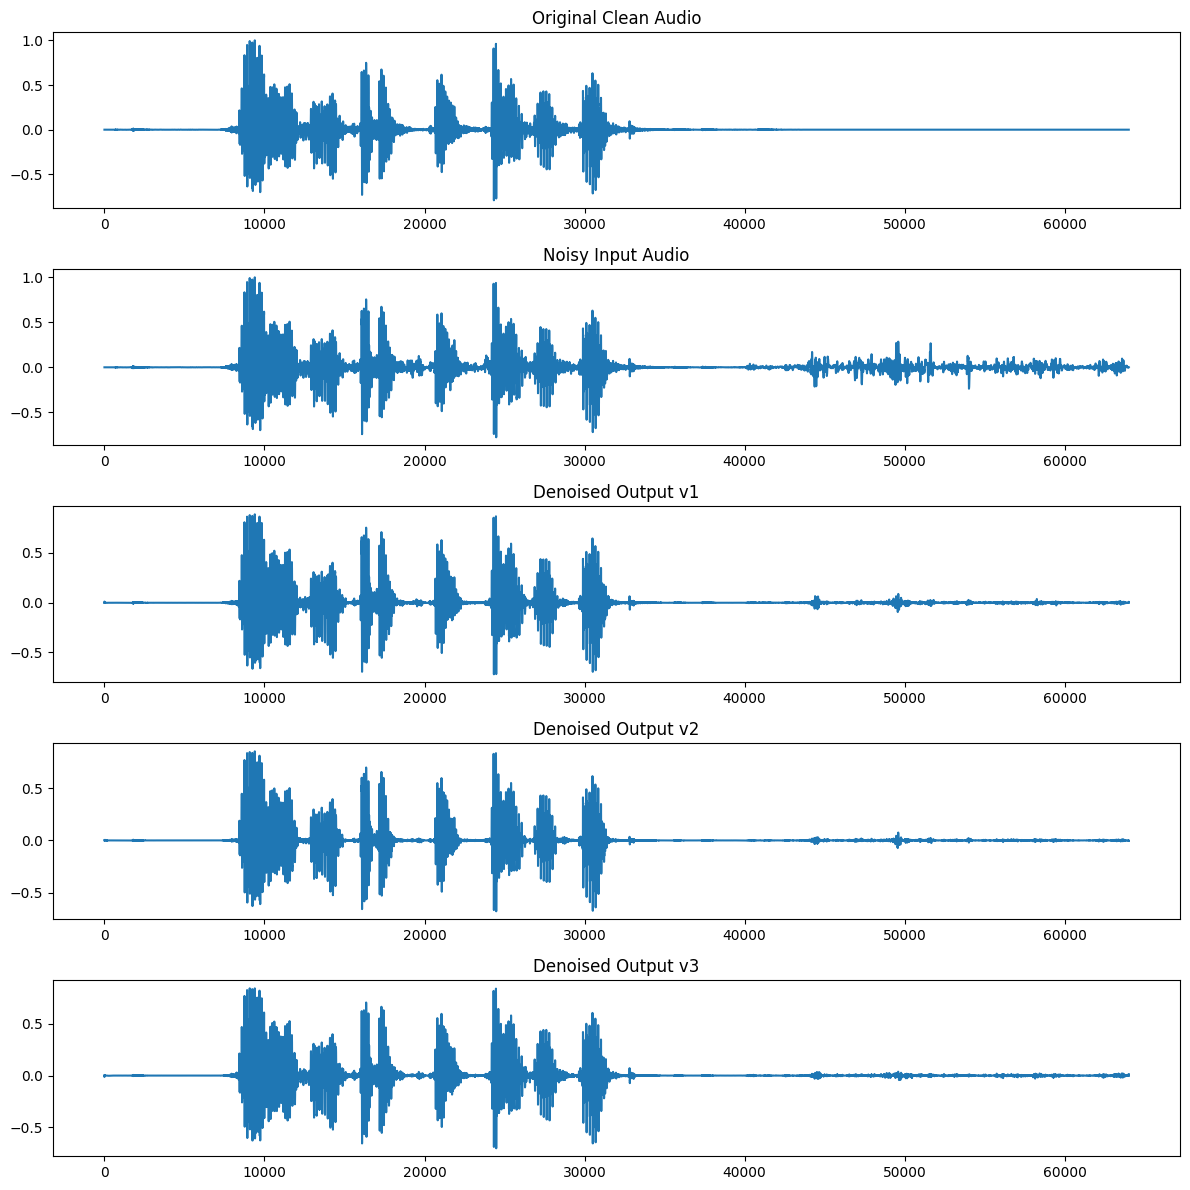

Clean:


Noisy:


V1 Denoised:


V2 Denoised:


V3 Denoised:


PESQ Score V1: 2.5426626205444336
STOI Score V1: 0.984135904844483
PESQ Score V2: 2.4914608001708984
STOI Score V2: 0.9767824703569542
PESQ Score V3: 2.733139753341675
STOI Score V3: 0.9862937008459921


In [66]:
# /content/drive/MyDrive/WaveUNetDataset/teststuff/clipsWav/
# /content/drive/MyDrive/WaveUNetDataset/teststuff/backgroundnoise/
test_prediction(
    model0,
    model1,
    model2,
    clean_files=glob.glob(os.path.join('/content/drive/MyDrive/WaveUNetDataset/teststuff/clipsWav/', "**", '*.wav'),recursive=True),
    noise_files=glob.glob(os.path.join('/content/drive/MyDrive/WaveUNetDataset/teststuff/backgroundnoise/', '**', '*.wav'), recursive=True),
    sr=16000,
    duration=4.0,
    snr_db=10
)



Below are an attempt at getting good hyperparameters by using Random Search. The results were unfortunatly worse than the starting hyperparameters.... Or so I thought, the model that used them slightly outperformed past models
--------------------------------------------------------

In [8]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.9 MB/s eta 0:00:00


In [9]:
import keras_tuner as kt

In [10]:
# In this block I will attempt to use a tool called "Karas Tuner" to find optimal
# hyperparameters, if all goes well model V3 might be the last one trained for this project
# Even if it does not go well, it might still be the last one due to time constraints

def build_model(hp):
  depths = hp.Int('depth', min_value=2, max_value=6, step=1)
  filterss = hp.Int('filters', min_value=16, max_value=64, step=8)
  learning_rate = hp.Choice('learning_rate', values=[1e-4, 3e-4, 1e-3])

  model = wave_unet(depth=depths, filters=filterss)
  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss='mean_squared_error',
    metrics=['mae']
    )
  return model

In [11]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='wave_unet_tuning'
)

In [13]:
tuner.search(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
    )

Trial 20 Complete [00h 15m 02s]
val_loss: 0.000740742078050971

Best val_loss So Far: 0.000715235248208046
Total elapsed time: 03h 43m 21s


In [14]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [16]:
best_hyperparams.values

{'depth': 5, 'filters': 24, 'learning_rate': 0.0001}

Below are an attempt to provide a streamlined way to use the model.
---------------

In [42]:
!pip install librosa soundfile

In [36]:
import tensorflow as tf

# Audio processing
import librosa
from IPython.display import Audio

import numpy as np

In [37]:
model = tf.keras.models.load_model('/content/drive/My Drive/waveunet_v3.keras') # Use the path to where the model is


In [38]:
sound, _ = librosa.load("/content/drive/MyDrive/WaveUNetDataset/teststuff/clipsWav/common_voice_nb-NO_42613615.wav", sr=16000) # Use the path to where the clip is

In [39]:
display(Audio(sound, rate=16000)) # Before

In [40]:
clean = sound[np.newaxis, ..., np.newaxis].astype(np.float32)
denoised = model.predict(clean)[0, :, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


In [41]:
display(Audio(denoised, rate=16000)) # After